I have used the following methods.

* I used a custom ResNet-50[1] architecture,
* The project took place using <b>Google TPU</b>,
* I used the validation set for testing
* <b>elu</b> activation function
* <b>A custom layer</b> for residual block,
* <span style="color:#e74c3c;"> <b>NOTE:</b> Of course, the accuracy metric is very high (if there is a data leakage between the train dataset and the test dataset, there is a problem named overfitting), but the loss metric continued decreasing and lastly the model has yielded reasonable results in respect of the confusion matrix. </span>


## Test Set Predictions
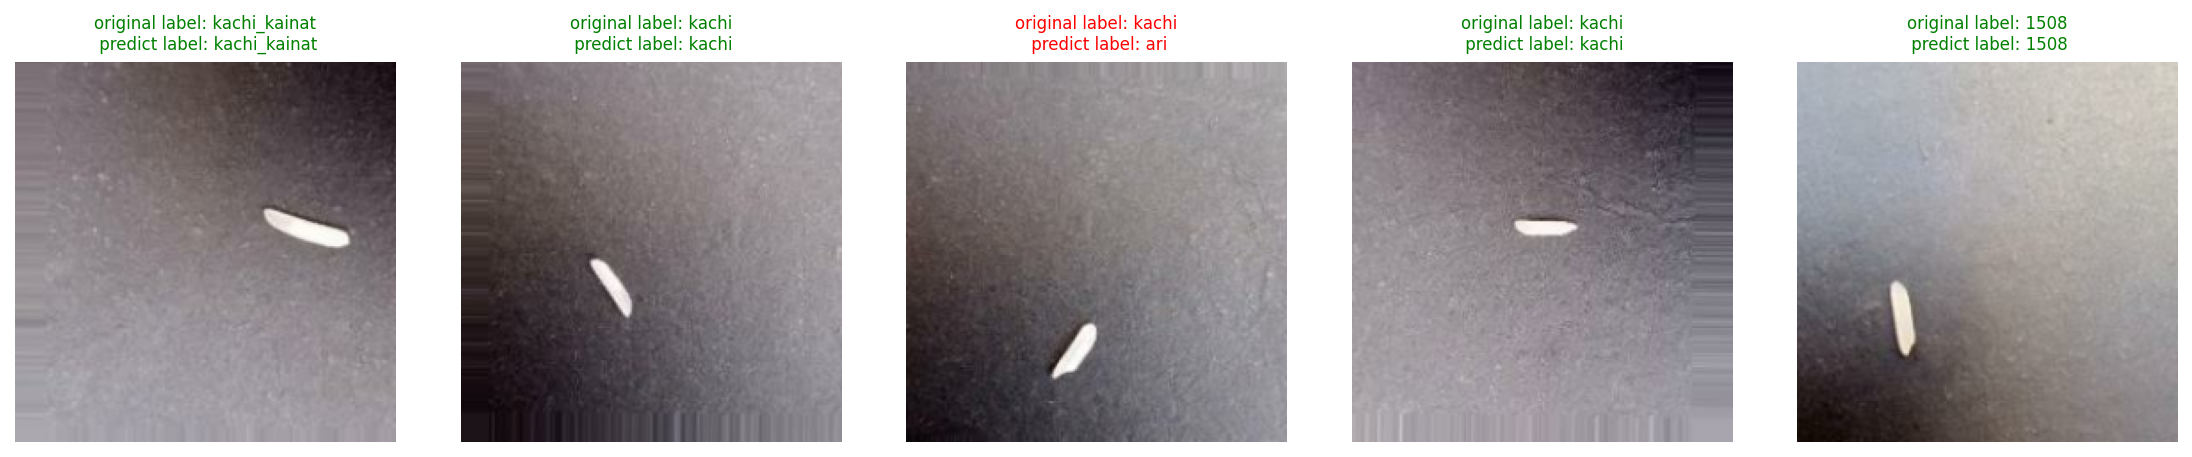

## References
1. He, K., Zhang, X., Ren, S., & Sun, J. (2015). Deep Residual Learning for Image Recognition (Version 1). arXiv. https://doi.org/10.48550/ARXIV.1512.03385

In [1]:
# Importing dependencies

import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Input, Conv2D, Dropout, BatchNormalization
from tensorflow.keras.layers import Activation, MaxPooling2D, Add, AveragePooling2D, Flatten,Dense



SEED1 = 10
NUM_CLASSES = 7
BATCH_SIZE = 128
IMG_SIZE = 214, 214

D0927 18:13:20.835568847      14 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0927 18:13:20.835593523      14 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0927 18:13:20.835597034      14 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0927 18:13:20.835599967      14 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0927 18:13:20.835602647      14 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0927 18:13:20.835605453      14 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0927 18:13:20.835608057      14 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0927 18:13:20.

In [2]:
# Connecting TPU and creating strategy and the model

tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
strategy = tf.distribute.TPUStrategy(tpu)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

# <span style="color:#e74c3c;"> Creating </span> Datasets


In [3]:
# Creating main dataframe contains image paths and their classes.

def create_images_list(path):
    full_path = []
    images = sorted(os.listdir(path))
    for i in images:
        full_path.append(os.path.join(path, i))
        
    return full_path


train_kachi_kainat = create_images_list('/kaggle/input/rice-seed-image-dataset-from-pakistan/Train/train_real/kachi_kainat')
train_1508 = create_images_list('/kaggle/input/rice-seed-image-dataset-from-pakistan/Train/train_real/1508')
train_kachi = create_images_list('/kaggle/input/rice-seed-image-dataset-from-pakistan/Train/train_real/kachi')
train_sufaid = create_images_list('/kaggle/input/rice-seed-image-dataset-from-pakistan/Train/train_real/Sufaid')
train_super = create_images_list('/kaggle/input/rice-seed-image-dataset-from-pakistan/Train/train_real/super')
train_ari = create_images_list('/kaggle/input/rice-seed-image-dataset-from-pakistan/Train/train_real/ari')
train_seela = create_images_list('/kaggle/input/rice-seed-image-dataset-from-pakistan/Train/train_real/Seela')


test_kachi_kainat = create_images_list('/kaggle/input/rice-seed-image-dataset-from-pakistan/Validation/val_real/kachi_kainat')
test_1508 = create_images_list('/kaggle/input/rice-seed-image-dataset-from-pakistan/Validation/val_real/1508')
test_kachi = create_images_list('/kaggle/input/rice-seed-image-dataset-from-pakistan/Validation/val_real/kachi')
test_sufaid = create_images_list('/kaggle/input/rice-seed-image-dataset-from-pakistan/Validation/val_real/Sufaid')
test_super = create_images_list('/kaggle/input/rice-seed-image-dataset-from-pakistan/Validation/val_real/super')
test_ari = create_images_list('/kaggle/input/rice-seed-image-dataset-from-pakistan/Validation/val_real/ari')
test_seela = create_images_list('/kaggle/input/rice-seed-image-dataset-from-pakistan/Validation/val_real/Seela')



# look-up table
classes = {0:'kachi_kainat', 1 : '1508', 2: 'kachi', 3:'sufaid', 4 : 'super', 5: 'ari', 6:'seela' }


train_df = pd.concat([ pd.DataFrame({ 'img' : train_kachi_kainat, 'class' : 0 }),
                       pd.DataFrame({'img': train_1508, 'class': 1 }),
                       pd.DataFrame({'img': train_kachi, 'class': 2 }),
                       pd.DataFrame({'img': train_sufaid, 'class': 3 }),
                       pd.DataFrame({'img': train_super, 'class': 4 }),
                       pd.DataFrame({'img': train_ari, 'class': 5 }),
                       pd.DataFrame({'img': train_seela, 'class': 6 })], ignore_index = True)


test_df = pd.concat([ pd.DataFrame({ 'img' : test_kachi_kainat, 'class' : 0 }),
                       pd.DataFrame({'img': test_1508, 'class': 1 }),
                       pd.DataFrame({'img': test_kachi, 'class': 2 }),
                       pd.DataFrame({'img': test_sufaid, 'class': 3 }),
                       pd.DataFrame({'img': test_super, 'class': 4 }),
                       pd.DataFrame({'img': test_ari, 'class': 5 }),
                       pd.DataFrame({'img': test_seela, 'class': 6 })], ignore_index = True)


train_df = shuffle(train_df, random_state = SEED1).reset_index(drop = True)
test_df = shuffle(test_df, random_state = SEED1).reset_index(drop = True)


# <span style="color:#e74c3c;"> Creating </span> tf.data Pipeline


In [4]:
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    
    return img, label

In [5]:
train_loader = tf.data.Dataset.from_tensor_slices((train_df['img'], train_df['class']))
train_dataset = (train_loader
                 .map(img_preprocessing)
                 .shuffle(train_df['img'].shape[0])
                 .batch(BATCH_SIZE)
                 .prefetch(BATCH_SIZE))


test_loader = tf.data.Dataset.from_tensor_slices((test_df['img'], test_df['class']))
test_dataset = (test_loader
                 .map(img_preprocessing)
                 .batch(BATCH_SIZE)
                 .prefetch(BATCH_SIZE))

# <span style="color:#e74c3c;"> Custom </span> Residual Block


In [6]:
class BottleneckResBlock(Layer):
    def __init__(self, filters, kernel_size, activation = 'relu', strides = 2, short = False, **kwargs ):
        super(BottleneckResBlock, self).__init__(**kwargs)
        self.filters = filters
        filters1 = filters[0]
        filters2 = filters[1]
        filters3 = filters[2]
        self.kernel_size = kernel_size
        self.activation = activation
        self.strides = strides
        self.short = short
        
        self.conv = Conv2D(filters3, kernel_size = 1, strides = strides)
        self.batch1 = BatchNormalization(axis=3)
        self.batch2 = BatchNormalization(axis=3)
        self.batch3 = BatchNormalization(axis=3)
        self.batch4 = BatchNormalization(axis=3)
        self.batch5 = BatchNormalization(axis=3)

        self.conv1 = Conv2D(filters1, kernel_size = 1, strides = strides, padding = 'valid')
        self.conv1_ = Conv2D(filters1, kernel_size = 1, strides = 1, padding = 'valid')
            
        self.conv2 = Conv2D(filters2, kernel_size = kernel_size, strides = 1 , padding = 'same')
        self.conv3 = Conv2D(filters3, kernel_size = 1, strides = 1, padding = 'valid')
        self.act = Activation(activation)

    
    def call(self, inputs):
        X_short = inputs
        X = inputs
        if self.short:
            X_short = self.conv(X_short)
            X_short = self.batch1(X_short)
            
            X = self.conv1(X)
            X = self.batch2(X)
            X = self.act(X)
        else:
            X = self.conv1_(inputs)
            X = self.batch3(X)
            X = self.act(X)
            
        X = self.conv2(X)
        X = self.batch4(X)
        X = self.act(X)
        
        X = self.conv3(X)
        X = self.batch5(X)
        
        
        X = Add()([X, X_short])
        X = self.act(X)
        return X

    def get_config(self):
        base_config = super().get_config()
        
        return {
            **base_config,
            "filters" : self.filters,
            "kernel_size": self.kernel_size,
            "activation" : self.act}

# <span style="color:#e74c3c;"> Custom ResNet-50 </span> Model


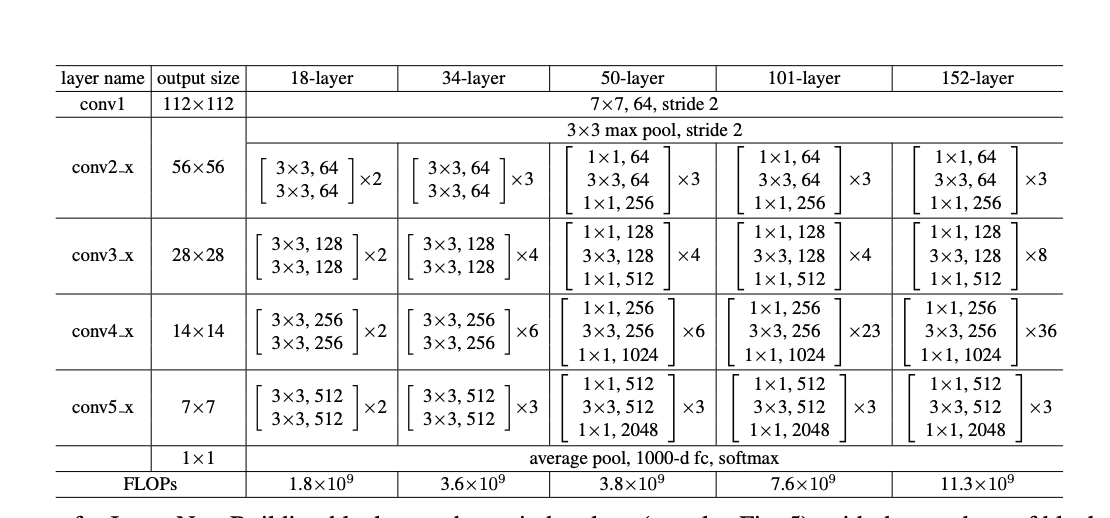
<br>
*ResNet architectures from the original paper[1]*

In [7]:
with strategy.scope():
    inp = Input(shape = (*IMG_SIZE, 3))

    X = Conv2D(64, (7, 7), strides=(2, 2), name='CONV_1')(inp)
    X = BatchNormalization(axis=3)(X)
    X = Activation('elu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    C = BottleneckResBlock([64,64,256], 3, strides = 1, short = True,  name='RES_BLOCK_1_1', activation = 'elu')(X)
    C = BottleneckResBlock([64,64,256], 3, name='RES_BLOCK_1_2',  activation = 'elu')(C)
    C = BottleneckResBlock([64,64,256], 3, name='RES_BLOCK_1_3',  activation = 'elu')(C)

    C = BottleneckResBlock([128, 128, 512], 3, strides = 2, short = True, name='RES_BLOCK_2_1',  activation = 'elu')(C)
    C = BottleneckResBlock([128, 128, 512], 3,  name='RES_BLOCK_2_2',  activation = 'elu')(C)
    C = BottleneckResBlock([128, 128, 512], 3,  name='RES_BLOCK_2_3',  activation = 'elu')(C)

    C = BottleneckResBlock([256, 256, 1024], 3, strides = 2, short = True,  name='RES_BLOCK_3_1', activation = 'elu')(C)
    C = BottleneckResBlock([256, 256, 1024], 3,  activation = 'elu',  name='RES_BLOCK_3_2')(C)
    C = BottleneckResBlock([256, 256, 1024], 3,  activation = 'elu',  name='RES_BLOCK_3_3')(C)
   
    C = BottleneckResBlock([512, 512, 2048], 3, strides = 2, short = True, name='RES_BLOCK_4_1', activation = 'elu')(C)
    C = BottleneckResBlock([512, 512, 2048], 3,  activation = 'elu',  name='RES_BLOCK_4_2')(C)
    C = BottleneckResBlock([512, 512, 2048], 3,  activation = 'elu',  name='RES_BLOCK_4_3')(C)
    
    C = AveragePooling2D(1)(C)

    C = Flatten()(C)
    C = Dense(NUM_CLASSES, activation = 'softmax')(C)

    model = Model(inputs = inp, outputs = C)
    #model.summary()
    
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001), loss = 'sparse_categorical_crossentropy', metrics  = ['Accuracy'])
    

# <span style="color:#e74c3c;"> Training </span> 


In [8]:
hist = model.fit(train_dataset, epochs = 15, batch_size = BATCH_SIZE )

Epoch 1/15


2023-09-27 18:14:12.143966: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-09-27 18:14:12.794254: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


62/62 [==============================] - 83s 508ms/step - loss: 1.3398 - Accuracy: 0.5672
Epoch 2/15
62/62 [==============================] - 6s 78ms/step - loss: 0.3859 - Accuracy: 0.8622
Epoch 3/15
62/62 [==============================] - 6s 76ms/step - loss: 0.1589 - Accuracy: 0.9589
Epoch 4/15
62/62 [==============================] - 5s 75ms/step - loss: 0.0839 - Accuracy: 0.9856
Epoch 5/15
62/62 [==============================] - 6s 76ms/step - loss: 0.0519 - Accuracy: 0.9949
Epoch 6/15
62/62 [==============================] - 5s 75ms/step - loss: 0.0376 - Accuracy: 0.9972
Epoch 7/15
62/62 [==============================] - 5s 75ms/step - loss: 0.0277 - Accuracy: 0.9985
Epoch 8/15
62/62 [==============================] - 5s 74ms/step - loss: 0.0222 - Accuracy: 0.9994
Epoch 9/15
62/62 [==============================] - 5s 74ms/step - loss: 0.0208 - Accuracy: 0.9983
Epoch 10/15
62/62 [==============================] - 5s 74ms/step - loss: 0.0145 - Accuracy: 0.9997
Epoch 11/15
62/62 

Text(0.5, 1.0, 'Train Metrics')

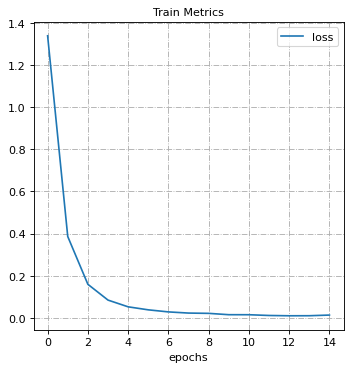

In [9]:
fig, axs = plt.subplots(1,1, figsize = (5,5), dpi = 80)

axs.grid(linestyle = 'dashdot')
axs.plot(hist.history['loss'])
axs.set_xlabel('epochs', fontsize = 10)
axs.legend(['loss'], fontsize = 10)
axs.set_title('Train Metrics', fontsize = 10)

# <span style="color:#e74c3c;"> Test </span> Evaluation

In [10]:
test_eval = model.evaluate(test_dataset)

2023-09-27 18:16:39.117947: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-09-27 18:16:39.332129: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


27/27 [==============================] - 21s 400ms/step - loss: 0.4216 - Accuracy: 0.8493


# <span style="color:#e74c3c;"> Test </span> Prediction

In [11]:
# Test set prediction

test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)
pred = model.predict(test_take1)
pred = np.argmax(pred, axis = 1)

2023-09-27 18:17:00.500186: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-09-27 18:17:00.691831: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


27/27 [==============================] - 20s 369ms/step


In [12]:
# A function that creating 5 random images in the test set and predictions

# Red title -> a false prediction
# Green title -> a true prediction

def random_test_sample_with_prediction():
    idxs = np.random.permutation(len(pred))[:5]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs
    

    fig, axs = plt.subplots(1,5, figsize = (15,3) ,dpi = 100)
    
    for i in range(5):
        image = test_take1_[batch_idx[i]][0][image_idx[i]]
        label = test_take1_[batch_idx[i]][1][image_idx[i]]
        pred_label = pred[idx[i]] 
        
        axs[i].imshow(image)
        axs[i].axis('off')
        
        if (label.numpy() == pred_label):
            axs[i].set_title("original label: " + classes[label.numpy()] + "\n predict label: " + classes[pred_label], fontsize = 8, color = 'green')
        else:
            axs[i].set_title("original label: " + classes[label.numpy()] + "\n predict label: " + classes[pred_label], fontsize = 8, color = 'red')

    
    plt.tight_layout()
    plt.show()

# <span style="color:#e74c3c;"> Sample </span> Test Predictions 

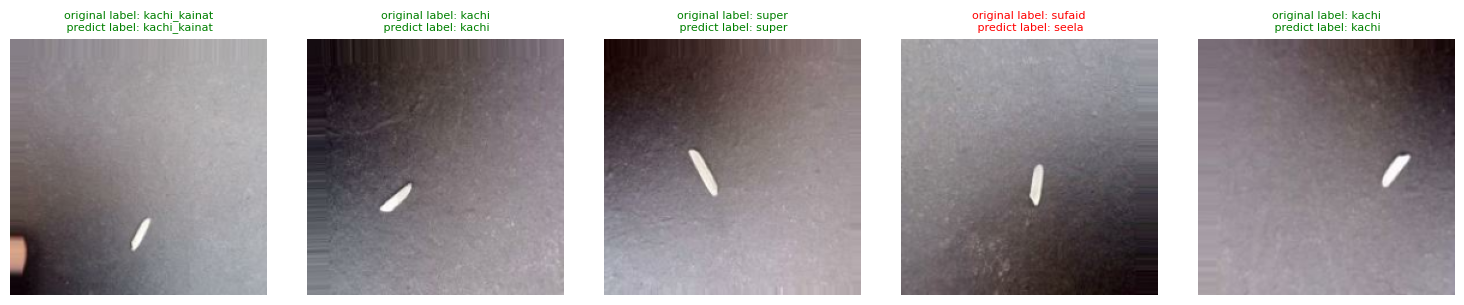

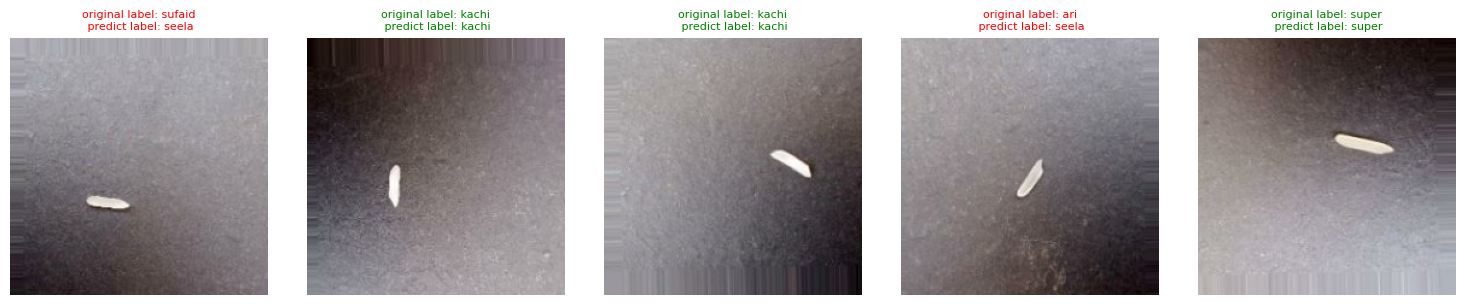

In [13]:
random_test_sample_with_prediction()
random_test_sample_with_prediction()

# <span style="color:#e74c3c;"> Classification </span> Report

In [14]:
clf = classification_report(test_df['class'] , pred, target_names = list(classes.values()) )
print(clf)

              precision    recall  f1-score   support

kachi_kainat       0.84      0.93      0.88       400
        1508       0.94      0.99      0.96       180
       kachi       0.89      0.93      0.91       550
      sufaid       0.81      0.69      0.75       590
       super       0.99      0.97      0.98       600
         ari       0.82      0.89      0.85       480
       seela       0.69      0.66      0.67       550

    accuracy                           0.85      3350
   macro avg       0.85      0.87      0.86      3350
weighted avg       0.85      0.85      0.85      3350



# <span style="color:#e74c3c;"> Confusion </span> Matrix

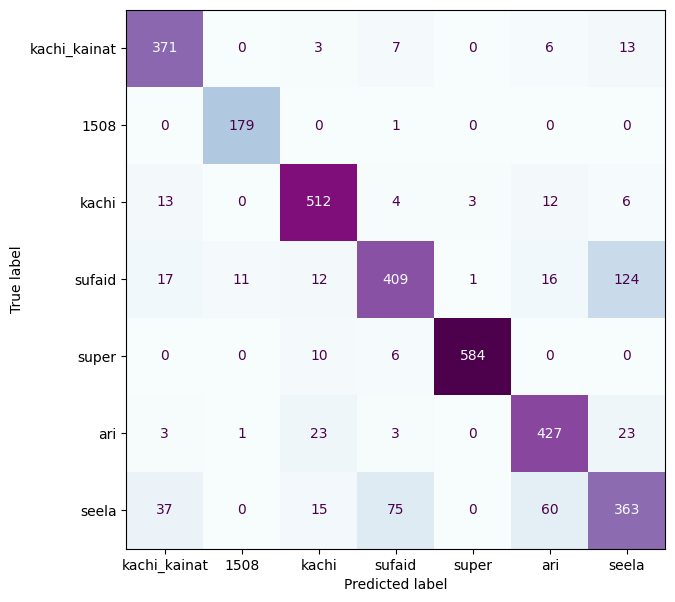

In [15]:
cm = confusion_matrix(test_df['class'] , pred)
cmd = ConfusionMatrixDisplay(cm, display_labels = list(classes.values()))

fig, ax = plt.subplots(figsize=(7,7))
cmd.plot(ax=ax,  cmap = 'BuPu', colorbar = False)